 # Job Bot par Axel, Fabien et Gabriel

## Objectif: 

Dans le cadre de notre notre formation, il nous a été demandé de mettre en place un Job bot soit un Bot qui va aller, 
via un script Python, chercher les offres d'emploi sur le site de Pole-Emploi avec des critères de recherche, tout cela dans le but de donner un aperçu du marché du travail en france( ou dans certaines régions) dans le milieu de l'informatique.

Nous résumons par la suite notre démarche pour la reussite de la mise en place de ce Job Bot.


## Principe fonctionnel:


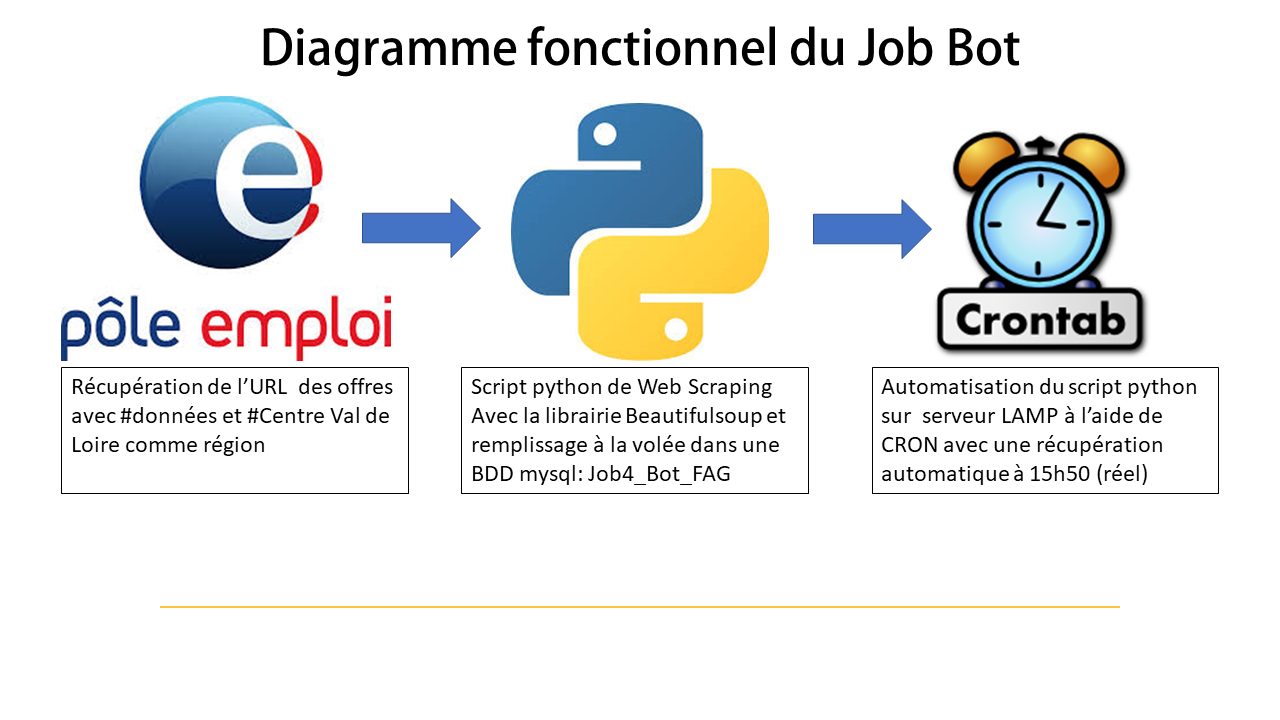

## Script Python de Web Scraping

## Ici, on procède a l'import des différentes librairies nécessaires dans le script Python pour le Job Bot.

In [1]:
#import des differentes librairies
import requests, json, sys, re, os, configparser
from bs4 import BeautifulSoup
#from sqlalchemy.sql import text
from sqlalchemy import create_engine, text
from urllib import parse
import pandas as pd
import argparse

### On selectionne le premier URL de base sur le site de Pole-emploi

In [2]:
BASE = 'https://candidat.pole-emploi.fr'

### On configure la connexion a notre BDD avec la librairie os +configparser ainsi que create_engine.

In [3]:

config = configparser.ConfigParser()
config.read_file(open(os.path.expanduser("datalab.cnf")))
#ici on configure notre nom de BDD
DB = "Job1_Bot_FAG?charset=utf8"
#ici la table
TBL = "Job4_Bot_FAG"
CNF="myBDD"
#On utilise create_engine qui va aller lire notre fichier CNF avec nos identifiants
engine = create_engine("mysql://%s:%s@%s/%s" % (config[CNF]['user'], parse.quote_plus(config[CNF]['password']), config[CNF]['host'], DB))

FileNotFoundError: [Errno 2] No such file or directory: 'datalab.cnf'

### On procède maintenant a la sélection de l'URL valide avec nos critères de recherche soit : Région Centre et Données et on en fait une soup via la librairie BeautifulSoup4:

In [ ]:
URL= BASE+'/offres/recherche?lieux=24R&motsCles=donn%C3%A9es&offresPartenaires=true&range=0-9&rayon=10&tri=0'
req = requests.get(URL)
# On crée la soupe
soup = BeautifulSoup(req.text, "lxml")

### On fait ressortir le nombre total d'offres via nos critères de recherches, il va nous servir par la suite:

In [ ]:
str = re.findall(r'\d+', soup.select('h1.title')[0].text)[0] # On réalise un REGEX pour le 1er chiffre !
N=int(str)
print("%d [%s]" % (N, URL))

### A partir de la nous commencons la boucle qui va aller récuperer les offres sur le site de Pole-Emploi par block de 100 offres puis les injecter dans notre Base de Données MySQL

#### On commence ici par écrire notre requete SQL qui va injecter les données dans la BDD avec les conditions d'update.

In [ ]:
statement = text("""
INSERT INTO Job4_Bot_FAG(ref, title, date1, dateLast, contrat, description, entreprise, dep, Ville, lien)
  VALUES(:ref, :title, :date, CURRENT_DATE(), :contrat, :description, :entreprise, :dep, :Ville, :lien)
ON DUPLICATE KEY
UPDATE
  title = :title,
  dateLast = CURRENT_DATE(),
  dep = :dep,
  lien= :lien,
  Ville = :Ville,
  entreprise = :entreprise
""")

#La table a été crée au préalable sur le serveur MySQL

### Puis on commence la Boucle et on configure ici la range qui va remplacer la range original dans l'URL (nombre d'offres par itération)

In [ ]:
i=0
while(i<N):
    imax = i+99 if (i+99<N) else N
    if imax>N:
        imax=N
    rg="%d-%d" % (i, imax)
    print(rg)
    ##URL avec rg en variable pour la range 
    URL=BASE+'/offres/recherche?lieux=24R&motsCles=donn%C3%A9es&offresPartenaires=true&range='+rg+'&rayon=10&tri=0'
    print("URL: "+URL)
    req = requests.get(URL)
    #ici on refait une soup dans la boucle avec le nouvel URL obtenu a chaque itération
    soup = BeautifulSoup(req.text, "lxml")
    list = soup.select('li.result')
    if len(list)==0:
        #return
        continue
    print("Nombre de blocks: %d [%s]" % (len(list), soup.select('h1.title')[0].text))
    for x in list:
        #Ici ce sont les informations que l'on a choisit d'extraire dans les offres avec du regex afin de les sortir propre
        #On resort les informations choisies via les balises html contenues dans la page
        a = x.select('a.btn-reset')[0]
        title = a['title'][:80] # ATTENTION: VARCHAR(80) !
        href = a['href']
        id = href[25:]
        #on selectionne ici l'information contenue dans la balise 'p' et de class date dans la page html ect.
        date1 = x.select('p.date')[0].text
        contrat = x.select('p.contrat')[0].text
        description = x.select('p.description')[0].text
        #On utilise une autre maniere de prendre l'information afin de combiner du regex pour nettoyer l'information voulue
        dep= (x.find('p', class_ ='subtext').find('span').text)[:3]
        entreprise = (x.find('p', class_ = 'subtext').text).split('-')[0]
        Ville= (x.find('p', class_ ='subtext').find('span').text)[5:]
        # On prend aussi le lien entier afin de permettre a l'utilisateur de retourner sur l'offre si besoin
        lien1 = BASE+x.find('a', class_ ='btn-reset')['href']
        param = {'ref': id, 'title':title, 'date':date1, 'contrat':contrat, 'description':description, 'entreprise':entreprise, 'dep':dep, 'Ville':Ville, 'lien':lien1}
        print(param)
        engine.execute(statement, param)
    
    #boucle par blocs de 100(le maximum autorisé étant de 150 dans notre cas)
    i+=100



## Par la suite étant donné que notre objetif est de concevoir un JobBot il nous reste a automatiser le script via un planificateur de tache . Dans notre cas nous allons utiliser l'outil CRON.

#### Pour utiliser l'outil CRON, nous allons passer par la console avec la commande crontab -e comme ci dessous :

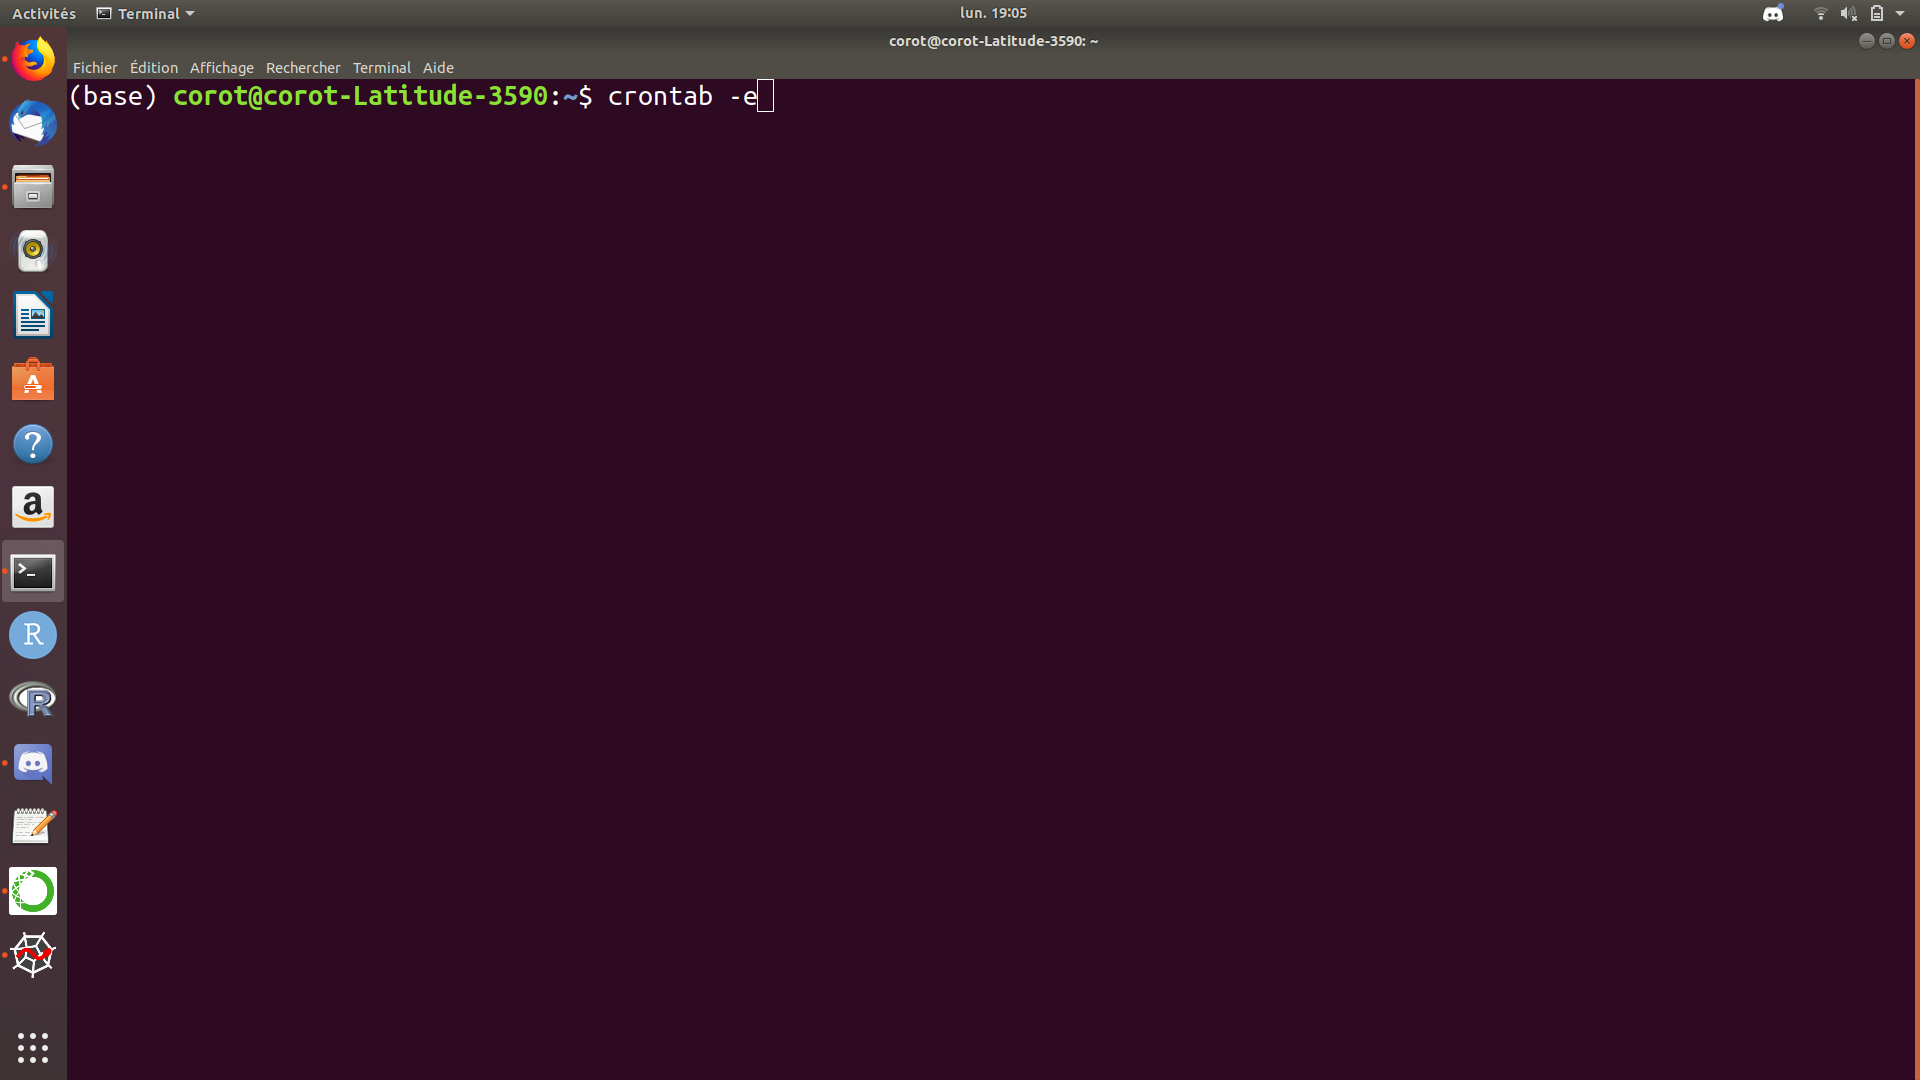

#### Puis on selectionne le premier des interface dans la liste déroulante ensuite on arrive dans la fenetre de configuration de l'outil CRON.

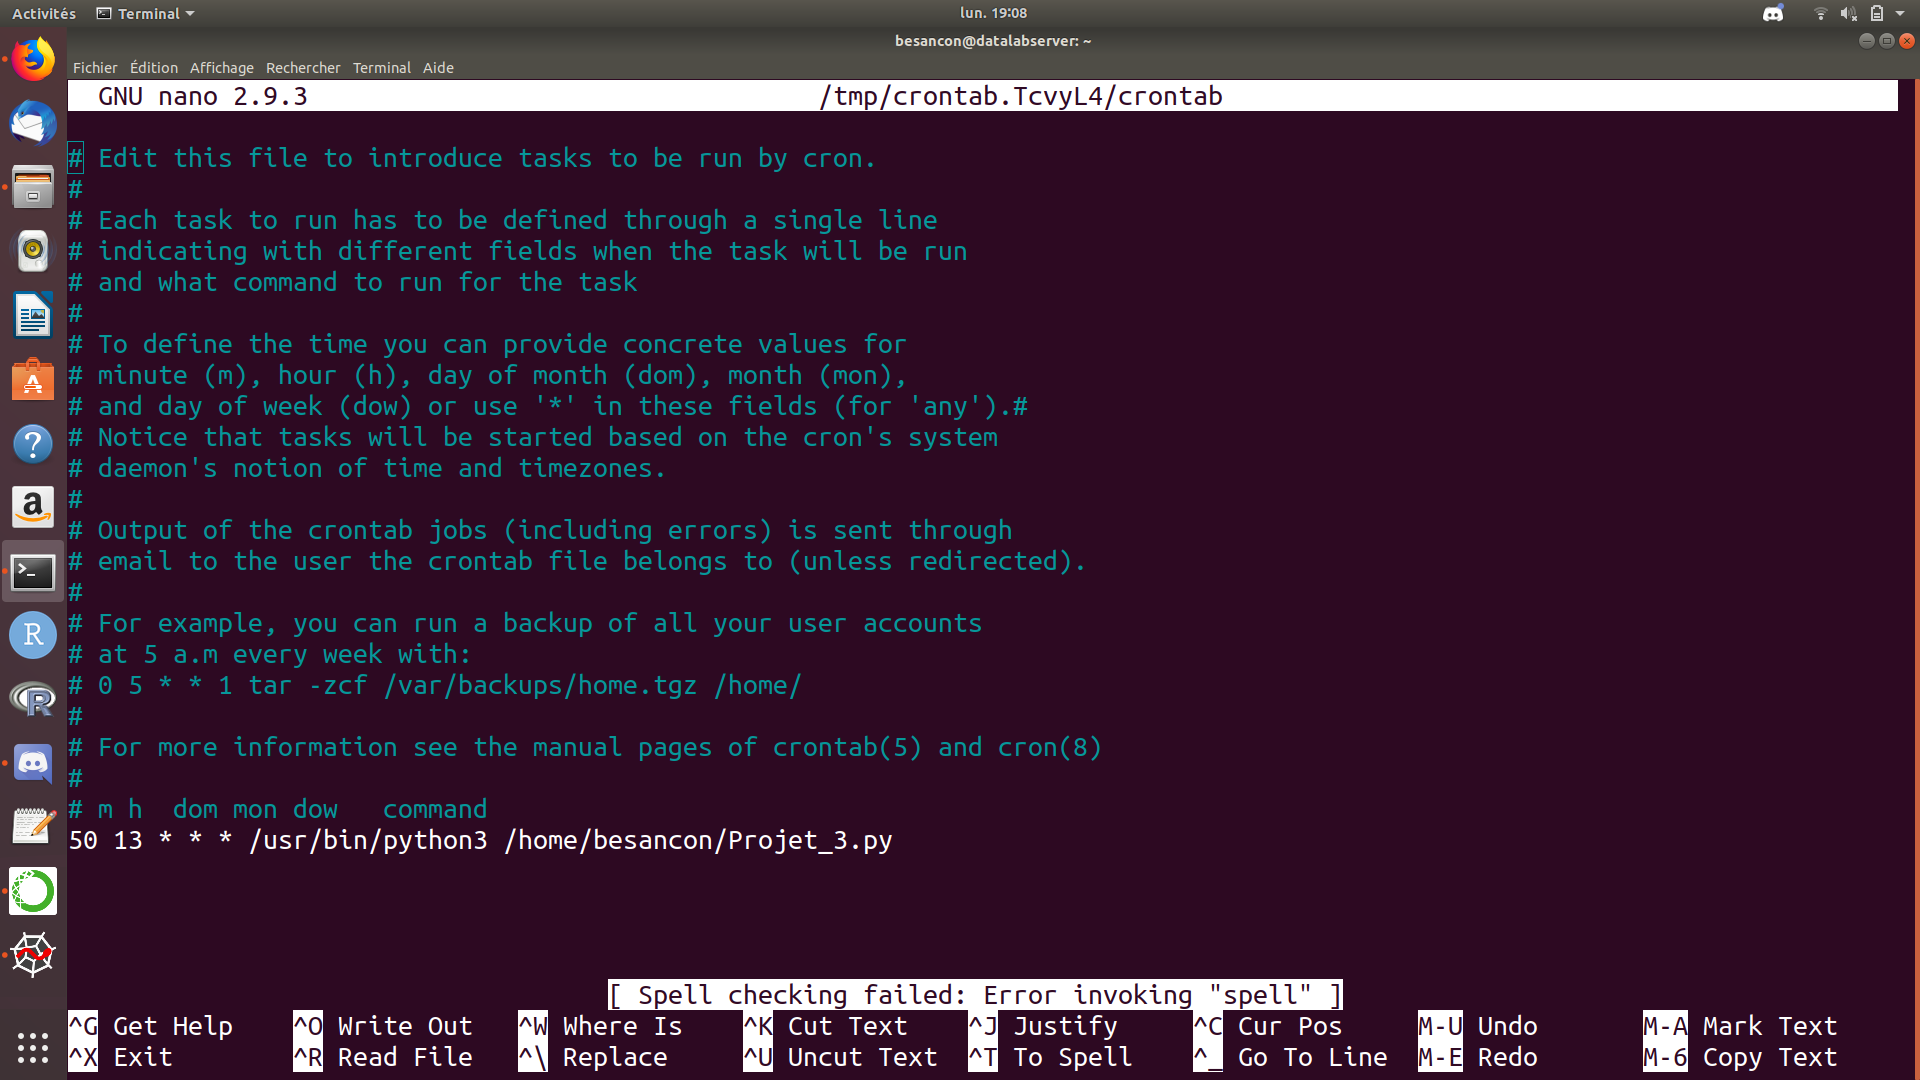

Dans cette fenetre ce que vous voyez en blanc est la ligne de commande ou je configure ma tache a automatisée dans notre cas nous exécutons notre script Python ou plutot notre Bot tout les hours a 15h50 heure locale.

Et voila vous avez un bot automatisé qui va aller Web Scrapper les offres d'emploi sur le site de Pole-Emploi et qui vous les insère dans votre Base de Données pour une utilisation future (dataviz , data analyse).

# Conclusion

## Les Bugs rencontrés

#### Dans notre cas , malgré les regex dans le script afin de ressortir les informations voulues, il reste quelques anomalies dans la table comme ci suit :

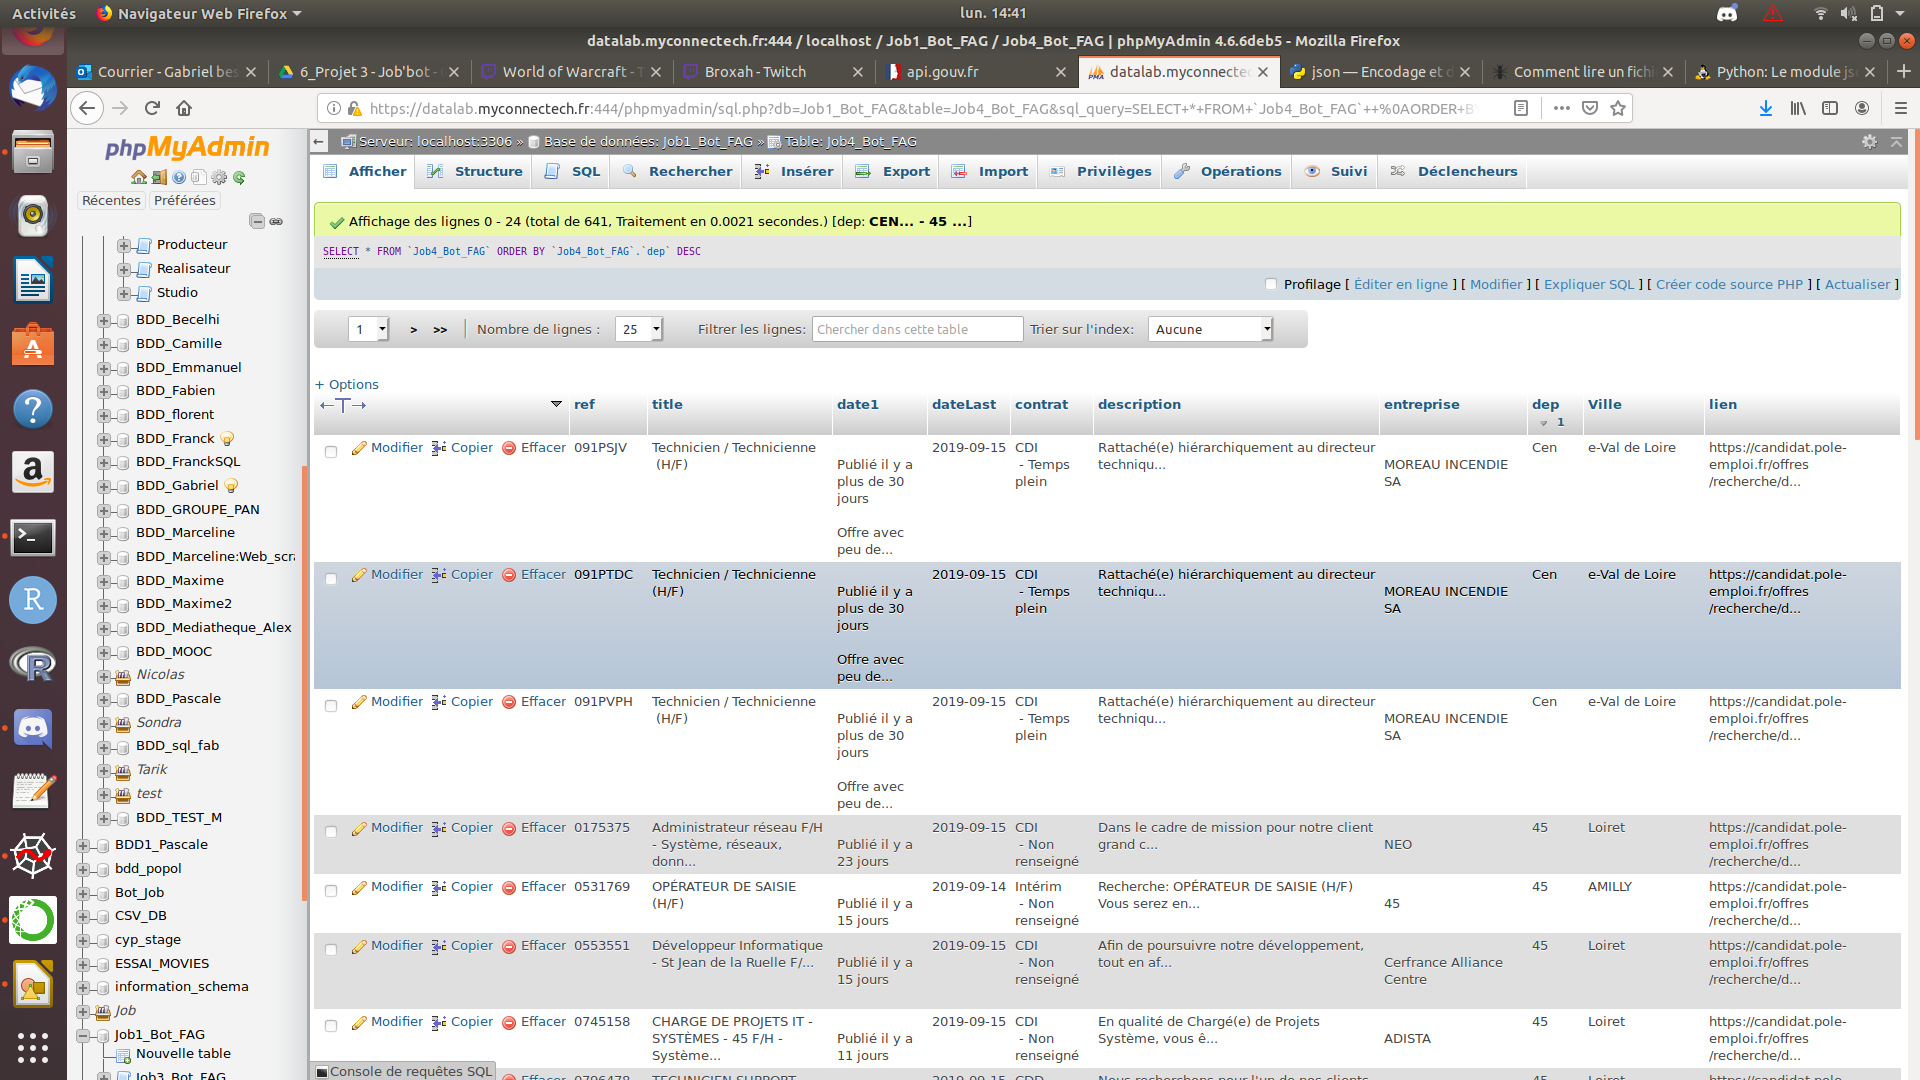

## Perspectives a venir pour le Bot:

_Idéalement il s'agirait de corriger toutes les erreurs encore présente lors de l'import dans la table ainsi que de combiner notre script avec celui d'Axel pour collecter plus d'informations utiles tels que le salaire, l'expérience et autres. Il est aussi possible de rajouter dans la code l'étape de création de la table sur le serveur MYSQL.

_Création d'une table: Listes des communes géolocalisées par régions, départements pour une analyse spatiale

_Réussir à connecter power BI à un serveur Lamp 

_Gérer les problèmes d'interclassement (UTF8bm4) lors de la récupération de la BDD en CSV qui générer des petits problèmes avec Power BI et des gros avec Tableaux Software 


## Comment analyser correctement le Big Bad Data après plusieurs semaine de récolte?

Notement les fausses offres qui font que la recherche Pôle Emploi+ Partenaires entrainent une décuplation de certaines offres!